In [1]:
#2.1 Loading the MNIST dataset

import tensorflow_datasets as tfds 
import tensorflow as tf

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
#tfds.show_examples(train_ds , ds_info)

# 2.2 Setting up the data pipeline

def data_pipeline(input, batch_size=64, prefetch_buffer_size=4):  
    # Map the dataset to extract images and labels
    input =input.map(lambda image, label: (image, label))
    # Reshape each image to a flat vector
    input = input.map(lambda image, label: (tf.reshape(image, (-1,)), label))   
    # Normalize(Scale) image values to be in the range [-1, 1]
    input = input.map(lambda image, label: ((tf.cast(image, tf.float32) / 128) - 1, label))     
    # One-hot encode the labels
    input = input.map(lambda image, label: (image, tf.one_hot(label, depth=10)))   
    # Shuffle the dataset and create batches of size 4
    input = input.shuffle(1024).batch(batch_size)
    # Prefetch the dataset to improve pipeline performance
    input = input.prefetch(prefetch_buffer_size)
    return input

# Save the datasets after applying the data pipeline
train_dataset = data_pipeline(train_ds)
test_dataset = data_pipeline(test_ds)

for elem in train_dataset.take(1):
    print(elem)
    
for elem in test_dataset.take(1):
    print(elem)

(<tf.Tensor: shape=(64, 784), dtype=float32, numpy=
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)>, <tf.Tensor: shape=(64, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 

2023-11-16 09:01:14.993535: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-16 09:01:15.031695: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [2]:
# 2.3 Building a deep neural network with TensorFlow
import tensorflow as tf
from tensorflow.keras import layers

class MLPModel(tf.keras.Model):
    def __init__(self, layer_sizes, output_size=10):
        super().__init__()
        self.mlp_layers = []  # create a list to store hidden layers

        # Create hidden layers with ReLU activation
        for layer_size in layer_sizes:
            new_layer = layers.Dense(units=layer_size, activation='relu')
            self.mlp_layers.append(new_layer)
        # Output layer with softmax activation for classification
        self.output_layer = layers.Dense(units=output_size, activation='softmax')

    def call(self, x):
        # Forward pass through hidden layers
        for mlp_layer in self.mlp_layers:
            x = mlp_layer(x)      
        # Forward pass through the output layer
        y = self.output_layer(x)
        return y


In [5]:
# 2.4 Training the network
"""
Define a training loop function which receives 
• The number of epochs
• The model object
• The training dataset
• The test dataset
• The loss function
• The optimizer
• Different arrays for the different values you want to track for visualization
"""


import tensorflow as tf
import numpy as np

def train_model(num_epochs, model, train_dataset, test_dataset, loss_function, optimizer):
    train_losses = []
    test_losses = []
    train_accuracies = []  # Track training accuracy
    test_accuracies = []   # Track testing accuracy

    for epoch in range(num_epochs):
        epoch_train_losses = []
        correct_train_predictions = 0  # Counter for correct training predictions
        total_train_samples = 0

        # Training phase
        for x_train, target_train in train_dataset:
            with tf.GradientTape() as tape:
                # Forward pass
                pred_train = model(x_train)
                # Calculate the training loss
                loss_train = loss_function(target_train, pred_train)
            
            # Calculate gradients
            gradients_train = tape.gradient(loss_train, model.trainable_variables)
            
            # Update weights using optimizer
            optimizer.apply_gradients(zip(gradients_train, model.trainable_variables))
            
            # Append the training loss to the list
            epoch_train_losses.append(loss_train.numpy())

            # Calculate training accuracy
            correct_train_predictions += np.sum(np.argmax(target_train, axis=1) == np.argmax(pred_train, axis=1))
            total_train_samples += len(x_train)

        train_accuracy = correct_train_predictions / total_train_samples
        train_accuracies.append(train_accuracy)

        # Testing phase
        epoch_test_losses = []
        correct_test_predictions = 0  # Counter for correct testing predictions
        total_test_samples = 0

        for x_test, target_test in test_dataset:
            # Forward pass
            pred_test = model(x_test)
            # Calculate the testing loss
            loss_test = loss_function(target_test, pred_test)
            epoch_test_losses.append(loss_test.numpy())

            # Calculate testing accuracy
            correct_test_predictions += np.sum(np.argmax(target_test, axis=1) == np.argmax(pred_test, axis=1))
            total_test_samples += len(x_test)

        test_accuracy = correct_test_predictions / total_test_samples
        test_accuracies.append(test_accuracy)

        # Print the mean training and testing loss and accuracy for the epoch
        mean_train_loss = np.mean(epoch_train_losses)
        mean_test_loss = np.mean(epoch_test_losses)
        print(f"Epoch {epoch + 1},\n Train Loss: {mean_train_loss}, Train Accuracy: {train_accuracy},\n Test Loss: {mean_test_loss}, Test Accuracy: {test_accuracy}")

        # Append losses to the lists for visualization
        train_losses.append(mean_train_loss)
        test_losses.append(mean_test_loss)

    return train_losses, test_losses, train_accuracies, test_accuracies

# Example usage
EPOCHS = 10
model = MLPModel(layer_sizes=[256, 256], output_size=10)

# Loss function and optimizer
cce = tf.keras.losses.CategoricalCrossentropy()
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.1)

# Assuming train_dataset and test_dataset are your TensorFlow datasets
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    EPOCHS, model, train_dataset, test_dataset, cce, sgd
)


Epoch 1,
 Train Loss: 0.34774839878082275, Train Accuracy: 0.8892333333333333,
 Test Loss: 0.1851961463689804, Test Accuracy: 0.9408
Epoch 2,
 Train Loss: 0.1380687952041626, Train Accuracy: 0.9576833333333333,
 Test Loss: 0.11170534044504166, Test Accuracy: 0.9645
Epoch 3,
 Train Loss: 0.09925451874732971, Train Accuracy: 0.9687666666666667,
 Test Loss: 0.09300845861434937, Test Accuracy: 0.9699
Epoch 4,
 Train Loss: 0.07752380520105362, Train Accuracy: 0.97595,
 Test Loss: 0.11440937966108322, Test Accuracy: 0.9614
Epoch 5,
 Train Loss: 0.06364576518535614, Train Accuracy: 0.98005,
 Test Loss: 0.18216168880462646, Test Accuracy: 0.9396
Epoch 6,
 Train Loss: 0.0527077354490757, Train Accuracy: 0.9835333333333334,
 Test Loss: 0.08652888983488083, Test Accuracy: 0.9744
Epoch 7,
 Train Loss: 0.04368864744901657, Train Accuracy: 0.9865333333333334,
 Test Loss: 0.0770178958773613, Test Accuracy: 0.9763
Epoch 8,
 Train Loss: 0.0359666608273983, Train Accuracy: 0.9887833333333333,
 Test Loss

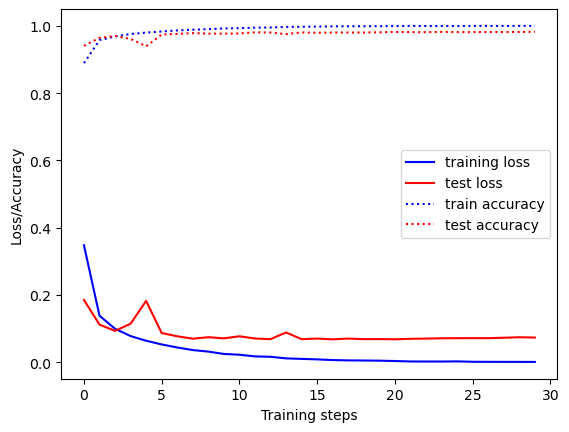

In [6]:
# 2. 5 Visualization 
import matplotlib.pyplot as plt
def visualization(train_losses , train_accuracies , test_losses , test_accuracies):
    """ 
    Visualizes accuracy and loss for training and test data using the mean of each epoch.
    Loss is displayed in a regular line, accuracy in a dotted line.
    Training data is displayed in blue, test data in red. Parameters
    ----------
    train_losses : numpy.ndarray
    training losses train_accuracies : numpy.ndarray
    training accuracies test_losses : numpy.ndarray
    test losses
    test_accuracies : numpy.ndarray
    test accuracies 
    """
    plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(test_losses, "r-") 
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(test_accuracies, "r:") 
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()
    

visualization(train_losses , train_accuracies , test_losses , test_accuracies)

# 3 Adjusting the hyperparameters of your model
 the learning rate
 batch size
 the number and size of layers of your model
 the optimizer
 